#DecisionTreeClassifier 사용하여 유방암 양성(2) 악성(4) 이진분류 모델로 정의

In [1]:
!pip install koreanize-matplotlib

##기본 패키지 임포트

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import pandas as pd
import numpy as np

## 데이터 준비하기

*https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original    original 사이트!

* UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기


In [3]:
#UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

df = pd.read_csv(uci_path, header = None)    # header 없는걸 확인할 수 있음  -> 컬럼명 지정이 필요함!
df

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [4]:
#컬럼명 지정

# shift

# 1. Sample code number:            id number
# 2. Clump Thickness:               1 - 10
# 3. Uniformity of Cell Size:       1 - 10
# 4. Uniformity of Cell Shape:      1 - 10
# 5. Marginal Adhesion:             1 - 10
# 6. Single Epithelial Cell Size:   1 - 10
# 7. Bare Nuclei:                   1 - 10
# 8. Bland Chromatin:               1 - 10
# 9. Normal Nucleoli:               1 - 10
# 10. Mitoses:                       1 - 10
# 11. Class:                        (2 for benign, 4 for malignant)
df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


## 데이터 전처리

In [6]:
# df['bare_nuclei'] -> object -> '?' -> np.nan 변경 -> 방법 두가지 .fillna() / .dropna() 중 선택 -> NaN 삭제
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [7]:
# np.nan 으로 변경
df['bare_nuclei'].replace('?',np.nan, inplace=True)
df['bare_nuclei'].isna().sum()

16

In [8]:
#dfdf['bare_nuclei'] NaN 데이터 삭제
df.dropna(axis=0, inplace=True)
df['bare_nuclei'].isna().sum()

0

In [9]:
#df['bare_nuclei']를 int 형으로 변환
df['bare_nuclei'] = df['bare_nuclei'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


## 데이터 분석 ( feature확인 )

### 예측하고자 하는 target(class 컬럼)의 비율 확인

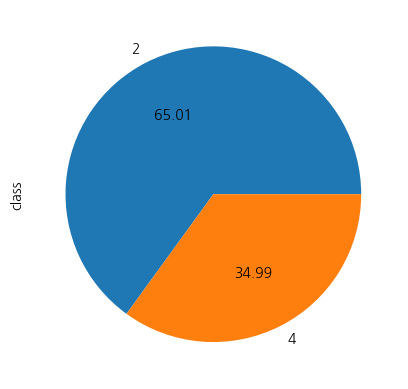

In [10]:
#class (2 for benign, 4 for malignant) 비율 확인! -> 데이터 셋의 불균형 , 균형 확인
df['class'].value_counts().plot.pie(autopct='%.2f');

<Axes: >

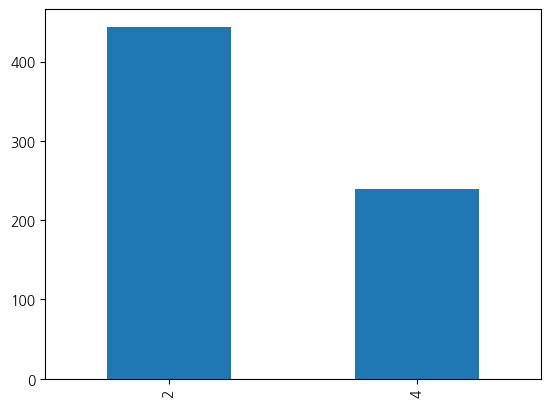

In [11]:
df['class'].value_counts().plot.bar()


###target과 feature 간의 연관성 확인

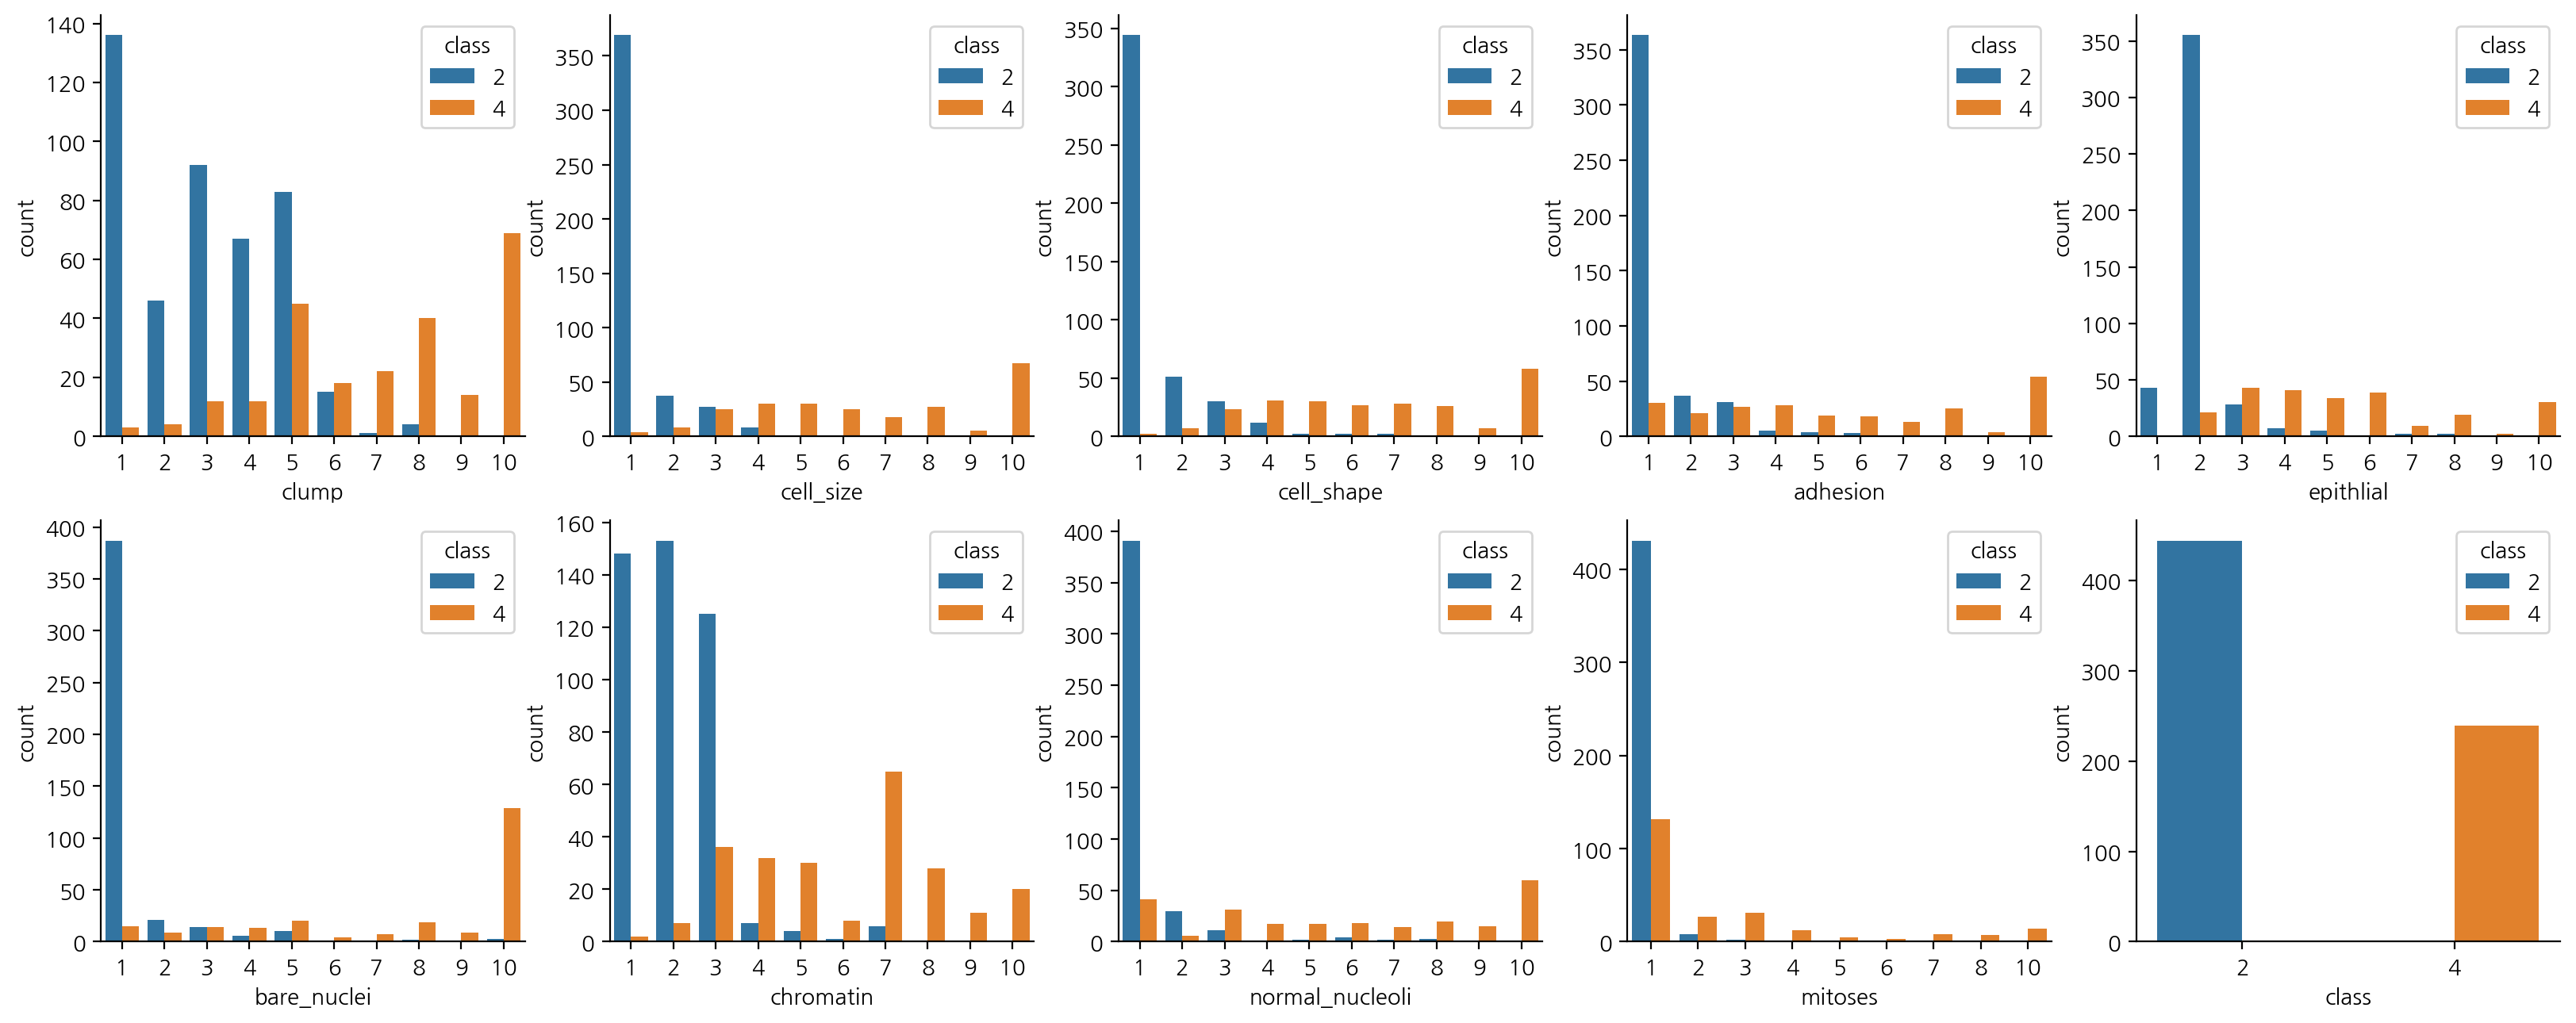

In [12]:
# id 컬럼을 제외한 Target과 Feature의 연관성 확인
attrs = df.columns[1:]
plt.figure(figsize=(20, 20), dpi=200)

for i, feature in enumerate(attrs):
    plt.subplot(5,5, i+1)
    sns.countplot(df, x= feature, hue='class')

sns.despine()

##데이터 분리하기!

### X,y 분리 -> trian과 test set으로

In [13]:
# X,y 분리 -> train_set / test_set으로 분리!
df.columns[1:-1]
df.columns[-1:]
X = df[df.columns[1:-1]]    # id, class 컬럼 제외한 Feature 데이터 프레임!
y = df[df.columns[-1]]

print(X,'\n', y)

     clump  cell_size  cell_shape  adhesion  epithlial  bare_nuclei  \
0        5          1           1         1          2            1   
1        5          4           4         5          7           10   
2        3          1           1         1          2            2   
3        6          8           8         1          3            4   
4        4          1           1         3          2            1   
..     ...        ...         ...       ...        ...          ...   
694      3          1           1         1          3            2   
695      2          1           1         1          2            1   
696      5         10          10         3          7            3   
697      4          8           6         4          3            4   
698      4          8           8         5          4            5   

     chromatin  normal_nucleoli  mitoses  
0            3                1        1  
1            3                2        1  
2            3    

###train_Set/ test_set 분리

In [14]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify = y, random_state=7 )

print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)


X_train.shape (478, 9)
X_test.shape (205, 9)


## DecisionTree 분류모델 설정!

In [15]:
#  max_depth 속성은 얼마나 가지를 뻗어 나갈지, 나무가지를 몇개의 층으로 만들지에 대한 것 , 적정한 레벨 값을 찾기 위한
# criterion = 'entropy' 나무를 만들 때의 계산식 선택하는 속성, 최적의 속성을 찾기위해
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)

##모델 학습하기

In [16]:
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

## 모델 예측하기

In [17]:
y_pred = tree_model.predict(X_test)

##모델 성능평가하기

In [18]:
print('훈련 데이터셋 정확도:', tree_model.score(X_train,y_train))
print('훈련 데이터셋 정확도:', tree_model.score(X_test,y_test))

훈련 데이터셋 정확도: 0.9769874476987448
훈련 데이터셋 정확도: 0.9463414634146341


### 트리에 대한 레포트!

In [19]:
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

              precision    recall  f1-score   support

           2       0.98      0.94      0.96       133
           4       0.90      0.96      0.93        72

    accuracy                           0.95       205
   macro avg       0.94      0.95      0.94       205
weighted avg       0.95      0.95      0.95       205



In [20]:
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
#print('precision: ', metrics.accuracy_score(y_tset, y_pred))
#print('recall: ', metrics.accuracy_recall_score(y_tset, y_pred))
#print('f1: ', metrics.accuracy_f1_score(y_tset, y_pred))


accuracy:  0.9463414634146341


## 결정트리 그래프 그리기

In [21]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file = 'tree.dot', class_names=['양성','악성'],
                feature_names = df.columns[1:10], impurity=False, filled=True)

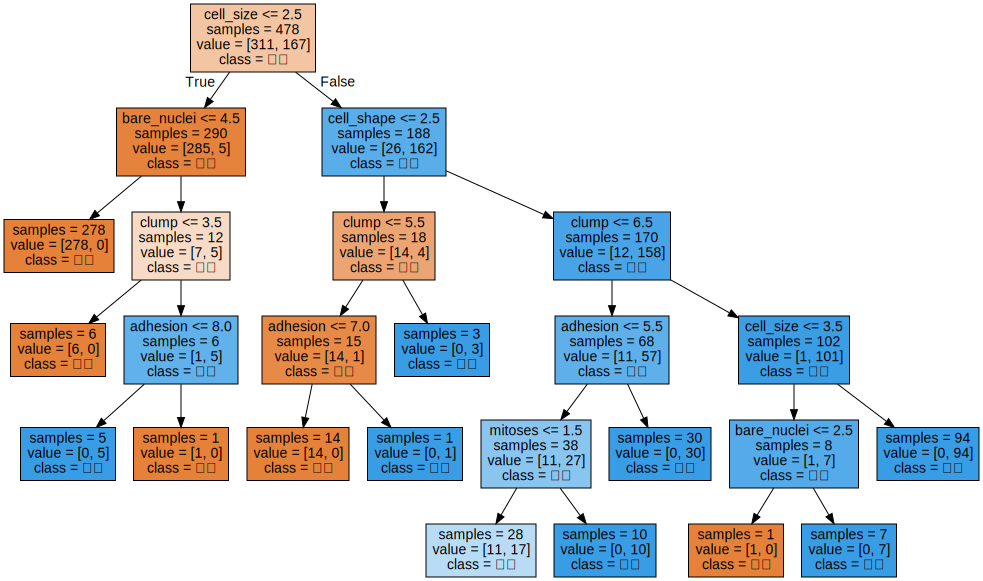

In [22]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))
# 가장 좋은 max_depth를 찾자!

## max_depth 변화에 따른 성능 평가

In [23]:
# 1~10 까지 Max_depth를 변화시켜 가장 최적의 max_dpeth 찾기
# max_depth와 train_socre를 페어로 얻고 싶음 -> 딕셔너리 쓰면 효율적!
train_scores = {}
test_scores = {}

# tree max_depth를 1~10 까지 증가시켜 정확도 측정
for idx in np.arange(1,11):

    tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)
    train_scores[idx] = tree_model.score(X_train, y_train)
    test_scores[idx] = tree_model.score(X_test, y_test)

# 훈련 테스트셋의 가장 높은 정확도의 max_depth 확인
max_train_key = max(train_scores, key = train_scores.get)
max_test_key = max(test_scores, key=test_scores.get)





print('훈련 데이터셋 최적의 max_depth:', max_train_key, ' 정확도:', train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth:',max_test_key, ' 정확도:', test_scores[max_train_key])


훈련 데이터셋 최적의 max_depth: 10  정확도: 1.0
테스트 데이터셋 최적의 max_depth: 6  정확도: 0.9414634146341463


##성능평가 시각화


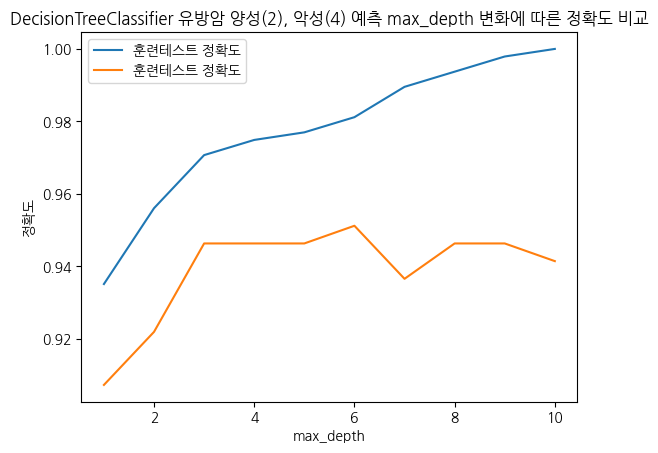

In [24]:
plt.title('DecisionTreeClassifier 유방암 양성(2), 악성(4) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label= '훈련테스트 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label= '훈련테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

# DecisionTreeClassifier 사용하여 유방암 양성(0), 악성(1) 이진분류 모델로 정의

* class컬럼의 값을 2-> 0 4-> 1로 변경
*기존 전처리 동일하게 진행!
* X,y 로 분리 후 X 값 정규화 ( preprocessiong.StrandardScaler() 사용)
* max_depth 1~ 20까지 변환하여, 최적점 찾기
*최적점 적용한 모델의 성능평가 (accuracy,precision, recall, f1
*모델 그래프 그리기

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


##class컬럼의 값을 2-> 0 4-> 1로 변경

In [43]:
from sklearn import preprocessing
ndf = df
c_o=ndf['class'].replace(2,0).replace(4,1)
# df['target] = np.whrere(df['class']==2, 0, 1)
ndf['class'] = c_o

In [44]:
X = ndf[ndf.columns[1:-1]]
y = ndf[ndf.columns[-1]]

In [45]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [46]:
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

In [30]:
y

0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: class, Length: 683, dtype: int64

##모델 학습하기

In [31]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify = y, random_state=7 )

In [32]:
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

## 최적값 및 시각화

In [33]:
# 1~10 까지 Max_depth를 변화시켜 가장 최적의 max_dpeth 찾기
# max_depth와 train_socre를 페어로 얻고 싶음 -> 딕셔너리 쓰면 효율적!
train_scores = {}
test_scores = {}

# tree max_depth를 1~10 까지 증가시켜 정확도 측정
for idx in np.arange(1,21):

    tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)
    train_scores[idx] = tree_model.score(X_train, y_train)
    test_scores[idx] = tree_model.score(X_test, y_test)

# 훈련 테스트셋의 가장 높은 정확도의 max_depth 확인
max_train_key = max(train_scores, key = train_scores.get)
max_test_key = max(test_scores, key=test_scores.get)





print('훈련 데이터셋 최적의 max_depth:', max_train_key, ' 정확도:', train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth:',max_test_key, ' 정확도:', test_scores[max_test_key])


훈련 데이터셋 최적의 max_depth: 10  정확도: 1.0
테스트 데이터셋 최적의 max_depth: 6  정확도: 0.9512195121951219


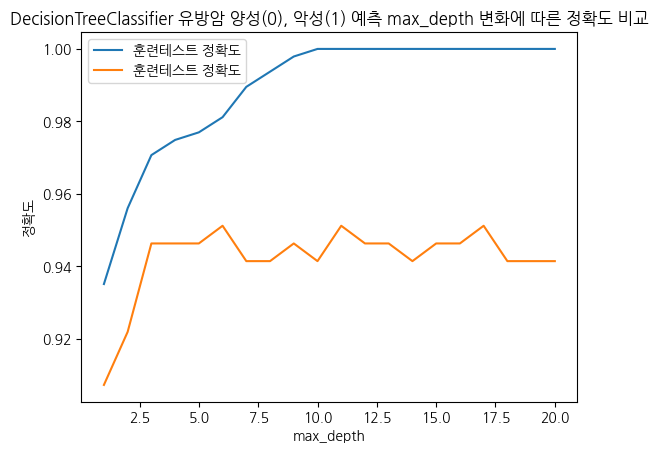

In [34]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label= '훈련테스트 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label= '훈련테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [35]:
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     133.0
           1       0.00      0.00      0.00      72.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0

    accuracy                           0.00     205.0
   macro avg       0.00      0.00      0.00     205.0
weighted avg       0.00      0.00      0.00     205.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [36]:
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 6)

In [37]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify = y, random_state=7 )

In [38]:
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [39]:
y_pred = tree_model.predict(X_test)

In [40]:
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred))  # 악성이라고 예측한 모델중에 실제 맞춘게 몇개인가
                                                            # ->틀려도 상관없는 추천 등의 정보에서는
print('recall: ', metrics.recall_score(y_test, y_pred))   # 실제 정답 중에서 모델이 맞춘 것(비율)은 몇개 인가
                                                         #   -> 틀리면 위한한경우 생명이 걸렸을 경우 recall이 중요!
print('f1: ', metrics.f1_score(y_test, y_pred))

accuracy:  0.9512195121951219
precision:  0.9558823529411765
recall:  0.9027777777777778
f1:  0.9285714285714286


## recall의 최적값 찾기

In [41]:
# 1~10 까지 Max_depth를 변화시켜 가장 최적의 max_dpeth 찾기
# max_depth와 train_socre를 페어로 얻고 싶음 -> 딕셔너리 쓰면 효율적!
test_precision = {}
test_recall = {}

# tree max_depth를 1~10 까지 증가시켜 정확도 측정
for idx in np.arange(1,21):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)

    y_pred = tree_model.predict(X_test)


    test_precision[idx] = metrics.precision_score(y_test,y_pred)
    test_recall[idx] = metrics.recall_score(y_test, y_pred)

# 훈련 테스트셋의 가장 높은 정확도의 max_depth 확인
max_precision_key = max(test_precision, key = test_precision.get)
max_recall_key = max(test_recall, key=test_recall.get)





print('최적의 precision max_depth:', max_precision_key, ' precision:',test_precision[max_precision_key])
print('최적의 recall max_depth:',max_recall_key, ' recall:', test_recall[max_recall_key])

최적의 precision max_depth: 6  precision: 0.9558823529411765
최적의 recall max_depth: 3  recall: 0.9583333333333334


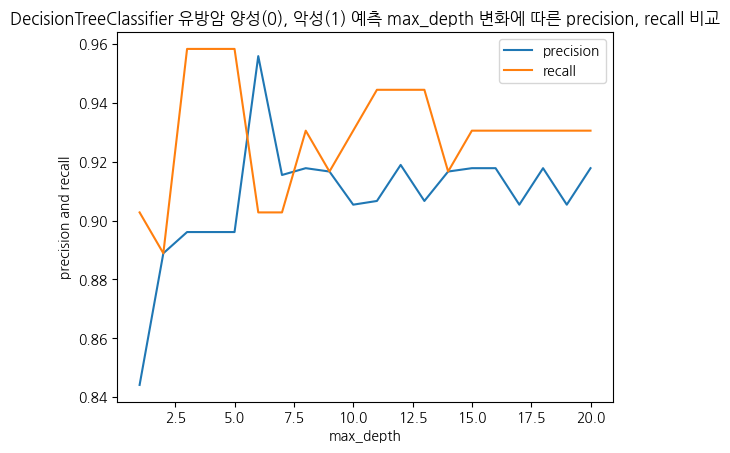

In [42]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 precision, recall 비교')

plt.plot(test_precision.keys(), test_precision.values(), label= 'precision')
plt.plot(test_recall.keys(), test_recall.values(), label= 'recall')

plt.ylabel('precision and recall')
plt.xlabel('max_depth')
plt.legend()
plt.show()